In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

### Load Data

In [2]:
SEISMIC_DATA = '/home/caesar/fdl/_geo/data/01_raw/data_sources/cushing_oklahoma/cushingSeismic.hdf5'
PRESSURE_DATA = '/home/caesar/fdl/_geo/data/01_raw/data_sources/cushing_oklahoma/cushingPressure.hdf5'

In [3]:
from orion_light import seismic_catalog
from orion_light import pressure_table

In [4]:
catalog = seismic_catalog.SeismicCatalog()
catalog.load_catalog_hdf5(SEISMIC_DATA)

In [5]:
pressure_model = pressure_table.PressureTableModel()
pressure_model.load_table(PRESSURE_DATA)

Loading pressure table from hdf5 file: /home/caesar/fdl/_geo/data/01_raw/data_sources/cushing_oklahoma/cushingPressure.hdf5


In [6]:
pressure_epoch = pressure_model.table_data['t'][1:]
p = pressure_model.table_data['pressure'][1:]
dpdt = pressure_model.table_data['dpdt'][1:]

t = np.linspace(np.amin(pressure_epoch), np.amax(pressure_epoch), num = 25000)
delta_t = t[1:] - t[:-1]

p = torch.FloatTensor(p)
dpdt = torch.FloatTensor(dpdt)
delta_t = torch.FloatTensor(delta_t)

In [24]:
len(p)

24999

### Select model parameters

In [20]:
site_info

{'tectonic_shear_stressing_rate': 1.1090830734910133e-05,
 'tectonic_normal_stressing_rate': 0,
 'sigma': 30000000.0,
 'biot': 0.3,
 'background_rate': 4.3095799427079375e-08,
 'init_delta_t': 29033.857421875}

In [7]:
mpa_yr2pa_s = 1e6 / 365.25 / 86400

site_info = {
    'tectonic_shear_stressing_rate' : 3.5e-4 * mpa_yr2pa_s, # Pa / s
    'tectonic_normal_stressing_rate' : 0, # Pa/s
    'sigma' : 30 * 1e6, # Pa
    'biot' : 0.3, # dimensionless
    'background_rate' : 1.36 / 365.25 / 86400, # event/second,
    'init_delta_t' : delta_t[0].item()
}

params = torch.FloatTensor([[
    0.73 - 0.155, # mu - alpha
    0.00264, # rate_coeff
    163.7424 / 1e6, # rate_factor 
]])

batch_size = 10
params = params.repeat(batch_size, 1)

params.requires_grad_();

### Run Model

In [11]:
from model import CRSModel

In [12]:
model = CRSModel(site_info)

In [13]:
Rt, Nt = model(params, p, dpdt, delta_t)

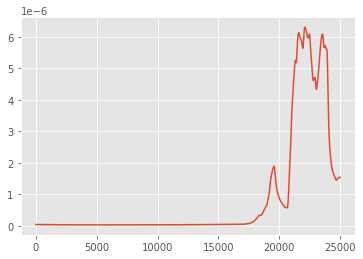

In [14]:
plt.figure()
plt.plot(Rt[0].data.numpy())
plt.show()

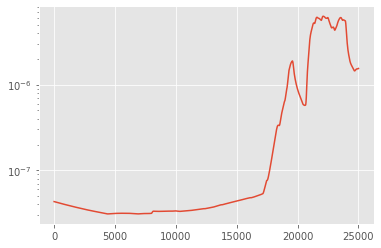

In [28]:
plt.figure()
plt.plot(Rt[0].data.numpy())
plt.yscale('log')
plt.show()

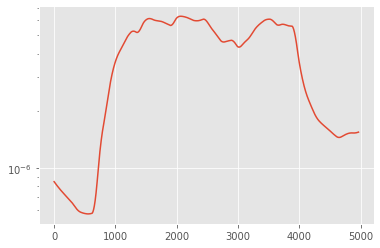

In [29]:
plt.figure()
plt.plot(Rt[0, 20035:].data.numpy())
plt.yscale('log')
plt.show()

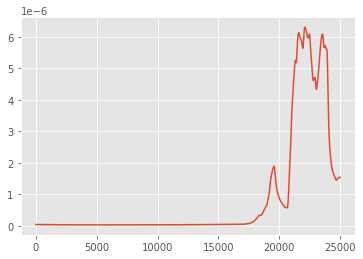

In [16]:
plt.figure()
plt.plot(Rt[0].data.numpy())
plt.show()

In [27]:
Rt[0, 20035]

tensor(8.4756e-07, grad_fn=<SelectBackward0>)

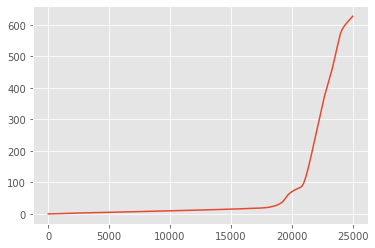

In [15]:
plt.figure()
plt.plot(Nt[0].data.numpy())
plt.show()

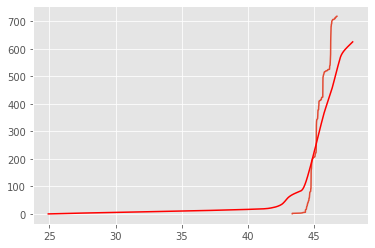

In [13]:
Mc = 1.6
catalog.set_slice(magnitude_range = [Mc, 10])
event_times = catalog.get_epoch_slice()

plt.plot(event_times/86400/365.25, np.linspace(1, len(event_times), len(event_times)))
cumulative_number = Nt[0].data.numpy()
plt.plot(t/86400/365.25, cumulative_number, color='r')

Backwards demo

In [14]:
test_loss = Rt.sum()
test_loss.backward()
params.grad.data

tensor([[ 3.9534e-02, -6.1559e-01,  1.2891e+02],
        [ 3.9534e-02, -6.1559e-01,  1.2891e+02],
        [ 3.9534e-02, -6.1559e-01,  1.2891e+02],
        [ 3.9534e-02, -6.1559e-01,  1.2891e+02],
        [ 3.9534e-02, -6.1559e-01,  1.2891e+02],
        [ 3.9534e-02, -6.1559e-01,  1.2891e+02],
        [ 3.9534e-02, -6.1559e-01,  1.2891e+02],
        [ 3.9534e-02, -6.1559e-01,  1.2891e+02],
        [ 3.9534e-02, -6.1559e-01,  1.2891e+02],
        [ 3.9534e-02, -6.1559e-01,  1.2891e+02]])